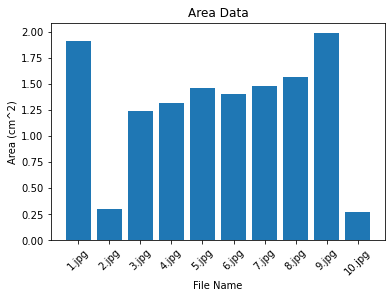

In [69]:
import cv2
import tkinter as tk
from tkinter import filedialog
from PIL import ImageTk, Image
import pandas as pd
import matplotlib.pyplot as plt

def calculate_area():
    # Load the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the image
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Clean up the image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Find the contours
    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate the area of the largest contour in cm^2
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        pixel_area = cv2.contourArea(largest_contour)

        # Scale conversion factor (pixels to centimeters)
        pixel_per_cm = 550  # Modify this value based on your image and object scale

        # Calculate the area in cm^2
        cm_area = pixel_area / (pixel_per_cm ** 2)
        result_label.config(text=f"Area: {cm_area:.2f} cm^2")

        # Update the area in the Excel sheet
        update_excel_sheet(file_name, cm_area)

    else:
        result_label.config(text='No contour found')

def open_image():
    # Open the file selection dialog
    file_path = filedialog.askopenfilename(filetypes=[('Image files', '*.jpg;*.jpeg;*.png')])

    if file_path:
        # Store the selected image file path
        global image_path
        image_path = file_path

        # Store the file name
        global file_name
        file_name = file_path.split('/')[-1]

        # Open the image file
        image = Image.open(image_path)

        # Resize the image to fit the GUI window
        image = image.resize((400, 300))

        # Convert the image to Tkinter format
        photo = ImageTk.PhotoImage(image)

        # Display the image in a label
        image_label.config(image=photo)
        image_label.image = photo

def update_excel_sheet(file_name, area):
    # Read the existing data from the Excel sheet
    try:
        df = pd.read_excel('leaf_area.xlsx')
    except FileNotFoundError:
        # If the file doesn't exist, create a new dataframe
        df = pd.DataFrame(columns=["File Name", "Area"])

    # Append the new file name and area to the dataframe
    new_row = {"File Name": file_name, "Area": area}
    df = df.append(new_row, ignore_index=True)

    # Save the dataframe to the Excel sheet
    df.to_excel('leaf_area.xlsx', index=False)

def plot_graph():
    # Read the data from the Excel sheet
    try:
        df = pd.read_excel('leaf_area.xlsx')
        file_names = df['File Name']
        areas = df['Area']

        # Plot the graph
        plt.bar(file_names, areas)
        plt.xlabel('File Name')
        plt.ylabel('Area (cm^2)')
        plt.title('Area Data')
        plt.xticks(rotation=45)
        plt.show()
    except FileNotFoundError:
        result_label.config(text='No data found')

# Create the main application window
window = tk.Tk()
window.title('Leaf Area Calculator')

# Create an image label to display the loaded image
image_label = tk.Label(window)
image_label.pack()

# Create a button to open the image
open_button = tk.Button(window, text='Open Image', command=open_image)
open_button.pack()

# Create a button to calculate the area
calculate_button = tk.Button(window, text='Calculate Area', command=calculate_area)
calculate_button.pack()

# Create a button to plot the graph
plot_button = tk.Button(window, text='Plot Graph', command=plot_graph)
plot_button.pack()

# Create a label to display the area result
result_label = tk.Label(window, text='')
result_label.pack()

# Start the Tkinter event loop
window.mainloop()
